### Authors: 
- Halidu Abdulai
- Pragati Manandhar

#### In this tutorial, we will be Illustrating heat equation discovery using the  DeepyMoD library: An equation discovery library which is built on top of the SinDy library. For simplicity, we will begin by demonstrating how the governing PDE of heat transfer across a rod can be discovered by considering one-dimensional case scenario. The partial differential equation governing the distribution of heat across a one-dimensional space is given by the following equation
#### $\frac{du}{dt}$ = $\alpha$($\frac{d^2u}{dx^2}$)
#### For d-dimension (e.g., 3-dimension), the equation becomes: $\frac{du}{dt}$ = $\alpha$($\frac{d^2u}{dx^2}$ + $\frac{d^2u}{dy^2}$ + $\frac{d^2u}{dz^2}$)

### we will try to model the distribution of heat across a uniform rod of length 10 units, which initially has high temperature at the middle of it and low (0 assumed) temperature at both extremes.

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

# DeePyMoD imports
from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.constraint import LeastSquares
from deepymod.model.func_approx import NN
from deepymod.model.library import Library1D, Library2D
from deepymod.model.sparse_estimators import Threshold
from deepymod.training import train
from deepymod.training.sparsity_scheduler import Periodic, TrainTest, TrainTestPeriodic

import warnings
warnings.filterwarnings('ignore')

### Check for the availability of GPU on device
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda


### Prepare the data

We will employ the explicit finite difference method to simulate heat distribution along a rod over time, based on the heat equation. The method discretizes the rod into spatial points and advances the simulation through discrete time steps. Temperature at each interior point is updated using a difference equation that approximates the heat equation's behavior. Boundary conditions maintain constant temperatures at the rod's ends, while an initial temperature profile is set across its length. The rule for updating the temperature at each time step is given by: $T_i^{(new)}$ = $T_i$ + $\alpha$ $\frac{dt}{dx^2}$ ($T_{i+1}$ - 2$T_i$ + $T_{i-1}$)

where:
- $T_i$ is the temperature at the $i^{th}$ spatial point at the current time step.
- $T_i^{(new)}$ is the temperature at the $i^{th}$ point at the next time step.
- $\alpha$ is the thermal diffusivity of the material (rod).
- dt and dx are the time step and space step sizes, respectively.
- $T_{i+1}$ and $T_{i-1}$ are the temperatures at the neighboring points to the right and left of the $i^{th}$ point.

In [24]:
data_path = "./datasets/heat_equation_data.csv"

In [25]:
def prepare_data(data_path:str, alpha:int) -> pd.DataFrame:
    # Parameters
    L = 10.0  # length of the rod
    T_left = 0.0  # temperature at the left end
    T_right = 0.0  # temperature at the right end
    T_middle = 100.0  # initial temperature in the middle of the rod
    alpha = alpha  # thermal diffusivity of the rod material
    dx = 0.1  # space step
    dt = 0.01  # time step
    N = int(L/dx)  # number of spatial points
    M = 1000  # number of time steps
    
    # Initial condition
    T = np.zeros(N)
    T[int(N/4):int(3*N/4)] = T_middle
    
    # Boundary conditions
    T[0] = T_left
    T[-1] = T_right
    
    # # Data collection
    data = []
    
    for t in range(M):
        T_new = T.copy()
        for i in range(1, N-1):
            T_new[i] = T[i] + alpha * dt / dx**2 * (T[i+1] - 2*T[i] + T[i-1])
        T = T_new
        T[0] = T_left
        T[-1] = T_right
        # Plot every 100 steps
        if t % 100 == 0:  
            plt.plot(np.linspace(0, L, N), T, label=f't={t*dt}')
            
        # Collecting data for each spatial point at the current time step
        for i in range(N):
            data.append([i*dx, t*dt, T[i]])
    
    # Convert the collected data to a DataFrame
    df = pd.DataFrame(data, columns=['x', 't', 'T'])
    
    # Save the collected data 
    df.to_csv(data_path, index=False)
    # Show the graph of the resulting plot
    plt.xlabel('Position along the rod')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()

    # Return the generated dataset
    return df

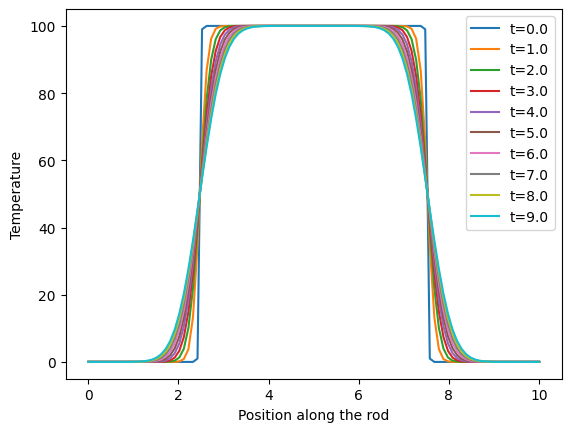

In [26]:
dataset = prepare_data(data_path=data_path, alpha=0.01)

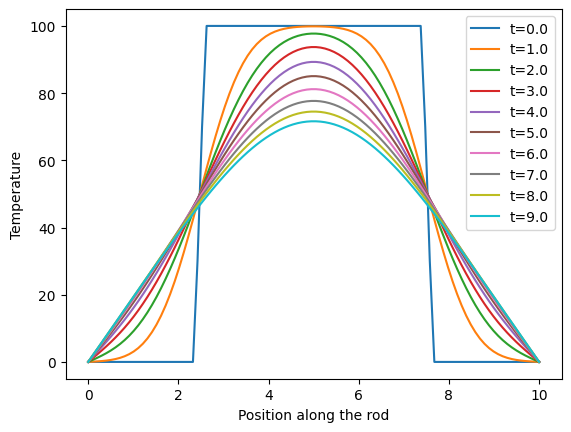

In [11]:
# Let's increase the value of alpha (thermal diffusivity) and see how quickly heat diffuses through the rod
_ = prepare_data(data_path=data_path, alpha=0.3)

##### Comments on the graph above:
-  The simulation starts with the rod having a uniform temperature at both ends, with a significantly higher temperature in the middle section. This initial state is represented by the first line on the graph (the highest peak at the beginnin)
- The temperatures at both ends of the rod (left and right) are kept constant throughout the simulation. These are the boundary conditions, and they are reflected in the graph by the flat lines at both ends of each curve.
- Over time, heat starts to diffuse from the hotter middle section towards the cooler ends. This process is driven by the temperature gradient (difference in temperature) between the middle and the ends of the rod. Heat flows from areas of high temperature to areas of low temperature, seeking equilibrium.
- As the simulation progresses (with each line representing a snapshot at different times), the temperature in the middle of the rod decreases while the temperature near the ends increases slightly, until the temperature distribution along the rod becomes more uniform. This trend continues until the heat distribution reaches a steady state, where all internal temperature gradients have dissipated, leading to a uniform temperature throughout the rod, if given enough time and no loss of heat to the environment.
- Each curve represents the temperature distribution along the rod at a specific point in time. The x-axis shows the position along the rod, and the y-axis represents the temperature. Early in the simulation, the curve is steep around the middle, indicating a significant temperature gradient. As time goes by, the curves become flatter and the temperature gradient decreases, demonstrating the equalization of temperature due to heat diffusion.

#### Now that we have the dataset simulated, let's try to use DeepyMod to see if we will be able to discover the underlying PDE. Let's keep it in mind that the case we are considering is 1-dimensional, and hence, the PDE we are seeking to discover is: $\frac{du}{dt}$ - $\alpha$($\frac{d^2u}{dx^2}$) = 0

In [12]:
def load_data_1D():
    """ The method loads the dataset and transforms it into the desired format (coords, data)"""
    data_1D = pd.read_csv(data_path)
    # Choose 'Machine_Temperature' and 'Production_Volume' as the spatial coordinates
    x = data_1D['x'].values
    t = data_1D['t'].values
    # Use 'Product_Quality' as the variable of interest
    u = data_1D['T'].values
    
    # Since our data doesn't naturally form a grid, we'll directly use 't', and 'x' as coordinates without meshgrid
    # This approach differs from spatial-temporal PDE data but aligns with the data's nature
    coords = np.vstack((t, x)).T
    coords = torch.from_numpy(coords).float()
    
    # Convert 'u' to a PyTorch tensor
    data = torch.from_numpy(u.reshape(-1, 1)).float()
    # print(f"Shape of coords: {coords.shape}")
    # print(f"Shape of data (u): {data.shape}")

    return coords, data

#### First, we will utilize the entire dataset to try to discover the PDE, and then subsample to see if we will be able to discover the same PDE

In [13]:
# Transform and return the dataset
dataset_1D = Dataset(
    load_data_1D,
    preprocess_kwargs={
        #"noise_level": 0.01,
        "normalize_coords": False,
        "normalize_data": True
    },
    #preprocess_kwargs = {"noise_level": 0.20},
    # subsampler=Subsample_random,
    # subsampler_kwargs={"number_of_samples": 2000},
    device=device,
)

Preprocessing data
Dataset is using device:  cpu


In [8]:
# Create a dataloader object for both the training and testing instances
train_dataloader, test_dataloader = get_train_test_loader(dataset_1D, train_test_split=0.8)
# Configure the network
network = NN(2, [50, 50, 50, 50], 1)
# Library
library = Library1D(poly_order=1, diff_order=2)
# Estimator
estimator = Threshold(0.2)
# Configuration of the sparsity scheduler
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5)
# Constraint
constraint = LeastSquares()

#### For Poly_order = 1, and diff_order=2, the library function contains the following 6 terms: $[1, u_x, u_{xx}, u, uu_{x}, uu_{xx}]$

In [9]:
model1D_1 = DeepMoD(network, library, estimator, constraint).to(device)

# Defining optimizer
optimizer = torch.optim.Adam(
    model1D_1.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3
)

In [10]:
%%time
foldername = "./data/deepymod/heat_model_1/"
train(
    model1D_1,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    log_dir=foldername,
    split=0.8,
    max_iterations=20000,
)

  8750  MSE: 3.26e-04  Reg: 8.85e-05  L1: 9.40e-01 Algorithm converged. Writing model to disk.
CPU times: total: 48min 6s
Wall time: 10min 29s


In [11]:
# Check the coefficient matrix of the model
model1D_1.constraint_coeffs()

[tensor([[0.0000],
         [0.0000],
         [0.0071],
         [0.0000],
         [0.0000],
         [0.0000]], device='cuda:0', grad_fn=<MaskedScatterBackward0>)]

In [13]:
# The sparsity mask shows which terms are active and which terms are inactive in the library function
model1D_1.sparsity_masks

[tensor([False, False,  True, False, False, False], device='cuda:0')]

In [14]:
model1D_1.estimator_coeffs()

[array([[0.        ],
        [0.        ],
        [0.91727793],
        [0.        ],
        [0.        ],
        [0.        ]], dtype=float32)]

##### Given that the library function is: $[1, u_x, u_{xx}, u, uu_{x}, uu_{xx}]$, the only active term in the library function is the term corresponding to $u_{xx}$ (in other words, the only active term is $\frac{d^2u}{dx^2}$. Thus, the recovered PDE is given by the equation $\frac{du}{dt}$ = $\alpha$($\frac{d^2u}{dx^2}$), where $\alpha$ = 0.0071, resulting in $\frac{du}{dt}$ = 0.0071($\frac{d^2u}{dx^2}$)

#### Next, let's subsample 1000 data points to see if we will end up discovering the PDE. Note: the entire dataset has 100,000 samples (Thus, we are using only 1% of the dataset in the following example

In [15]:
# Transform and return the dataset
dataset_1_percent = Dataset(
    load_data_1D,
    preprocess_kwargs={
        #"noise_level": 0.01,
        "normalize_coords": False,
        "normalize_data": True
    },
    #preprocess_kwargs = {"noise_level": 0.20},
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 1000},
    device=device,
)

Preprocessing data
Dataset is using device:  cuda


In [20]:
# Create a dataloader object for both the training and testing instances
train_dataloader, test_dataloader = get_train_test_loader(dataset_1_percent, train_test_split=0.8)

# Configure the network
network = NN(2, [50, 50, 50, 50], 1)
# Library
library = Library1D(poly_order=1, diff_order=2)
# Estimator
estimator = Threshold(0.3)
# Configuration of the sparsity scheduler
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5)
# Constraint
constraint = LeastSquares()

# define the model
model_1p = DeepMoD(network, library, estimator, constraint).to(device)
# Defining optimizer
optimizer = torch.optim.Adam(
    model_1p.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3
)

In [21]:
%%time
foldername = "./data/deepymod/heat_model_1p/"
train(
    model_1p,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    log_dir=foldername,
    split=0.8,
    max_iterations=20000,
)

 15000  MSE: 7.64e-05  Reg: 6.77e-05  L1: 9.75e-01 Algorithm converged. Writing model to disk.
CPU times: total: 53.1 s
Wall time: 4min 39s


In [22]:
model_1p.constraint_coeffs()

[tensor([[0.0000],
         [0.0000],
         [0.0078],
         [0.0000],
         [0.0000],
         [0.0000]], device='cuda:0', grad_fn=<MaskedScatterBackward0>)]

In [23]:
model_1p.sparsity_masks

[tensor([False, False,  True, False, False, False], device='cuda:0')]

In [24]:
model_1p.estimator_coeffs()

[array([[0.       ],
        [0.       ],
        [0.9408845],
        [0.       ],
        [0.       ],
        [0.       ]], dtype=float32)]

#### Again, the discovered PDE is $\frac{du}{dt}$ = $\alpha$($\frac{d^2u}{dx^2}$), where $\alpha$ = 0.0078, resulting in $\frac{du}{dt}$ = 0.0078($\frac{d^2u}{dx^2}$)

#### How about utilizing only 0.5% of the dataset?

In [25]:
# Transform and return the dataset
dataset_0_5_percent = Dataset(
    load_data_1D,
    preprocess_kwargs={
        #"noise_level": 0.01,
        "normalize_coords": False,
        "normalize_data": True
    },
    #preprocess_kwargs = {"noise_level": 0.20},
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 500},
    device=device,
)

Preprocessing data
Dataset is using device:  cuda


In [27]:
# Create a dataloader object for both the training and testing instances
train_dataloader, test_dataloader = get_train_test_loader(dataset_0_5_percent, train_test_split=0.8)

# Configure the network
network = NN(2, [50, 50, 50, 50], 1)
# Library
library = Library1D(poly_order=1, diff_order=2)
# Estimator
estimator = Threshold(0.2)
# Configuration of the sparsity scheduler
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5)
# Constraint
constraint = LeastSquares()

# define the model
model_0_5p = DeepMoD(network, library, estimator, constraint).to(device)
# Defining optimizer
optimizer = torch.optim.Adam(
    model_0_5p.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3
)

In [28]:
%%time
foldername = "./data/deepymod/heat_model_0_5p/"
train(
    model_0_5p,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    log_dir=foldername,
    split=0.8,
    max_iterations=20000,
)

  7625  MSE: 3.86e-05  Reg: 4.03e-05  L1: 9.67e-01 Algorithm converged. Writing model to disk.
CPU times: total: 23.8 s
Wall time: 2min 16s


In [29]:
model_0_5p.constraint_coeffs()

[tensor([[0.0000],
         [0.0000],
         [0.0086],
         [0.0000],
         [0.0000],
         [0.0000]], device='cuda:0', grad_fn=<MaskedScatterBackward0>)]

In [30]:
model_0_5p.sparsity_masks

[tensor([False, False,  True, False, False, False], device='cuda:0')]

In [31]:
model_0_5p.estimator_coeffs()

[array([[0.        ],
        [0.        ],
        [0.93155706],
        [0.        ],
        [0.        ],
        [0.        ]], dtype=float32)]

#### Yet again, the discovered PDE is $\frac{du}{dt}$ = $\alpha$($\frac{d^2u}{dx^2}$), where $\alpha$ = 0.0086, resulting in $\frac{du}{dt}$ = 0.0086$\frac{d^2u}{dx^2}$

#### But how about even training with as few data points as 50?

In [14]:
# Transform and return the dataset
dataset_0_05_percent = Dataset(
    load_data_1D,
    preprocess_kwargs={
        #"noise_level": 0.01,
        "normalize_coords": False,
        "normalize_data": True
    },
    #preprocess_kwargs = {"noise_level": 0.20},
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 50},
    device=device,
)

Preprocessing data
Dataset is using device:  cpu


In [15]:
# Create a dataloader object for both the training and testing instances
train_dataloader, test_dataloader = get_train_test_loader(dataset_0_05_percent, train_test_split=0.8)

# Configure the network
network = NN(2, [50, 50, 50, 50], 1)
# Library
library = Library1D(poly_order=1, diff_order=2)
# Estimator
estimator = Threshold(0.2)
# Configuration of the sparsity scheduler
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5)
# Constraint
constraint = LeastSquares()

# define the model
model_0_05p = DeepMoD(network, library, estimator, constraint).to(device)
# Defining optimizer
optimizer = torch.optim.Adam(
    model_0_05p.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3
)

In [16]:
%%time
foldername = "./data/deepymod/heat_model_0_05p/"
train(
    model_0_05p,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    log_dir=foldername,
    split=0.8,
    max_iterations=20000,
)

  4325  MSE: 7.93e-05  Reg: 7.41e-05  L1: 9.90e-01 Algorithm converged. Writing model to disk.
CPU times: total: 5min 17s
Wall time: 46.6 s


In [17]:
model_0_05p.constraint_coeffs()

[tensor([[0.0000],
         [0.0000],
         [0.2573],
         [0.0000],
         [0.0000],
         [0.0000]], grad_fn=<MaskedScatterBackward0>)]

In [18]:
model_0_05p.sparsity_masks

[tensor([False, False,  True, False, False, False])]

In [19]:
model_0_05p.estimator_coeffs()

[array([[0.       ],
        [0.       ],
        [0.9727996],
        [0.       ],
        [0.       ],
        [0.       ]], dtype=float32)]

##### Ha, even as small as 50 samples, we are able to discover the PDE. But notice that the true value of alpha (the thermal diffusivity coeff) is far from its true value (0.2 >> 0.01) ? This might suggest that, even though the underlying PDE could be discover by using small number of sample, it might not do well in providing the true (or close to true) coefficient value(s).

##### Next, we will model and discover the heat equation considering a 2D metal plate. The basic idea remains the same as that of 1D, except that 2D space considered. The PDE we are seeking to discover is given by the following equation: $\frac{du}{dt}$ = $\alpha$($\frac{d^2u}{dx^2}$ + $\frac{d^2u}{dy^2}$)

#### Preparing the 2D dataset

In [2]:
def prepare_data_2d(data_path: str, alpha:int=0.2) -> pd.DataFrame:
    # dimensions of the plate
    Lx, Ly = 10.0, 10.0  
    # boundary temperatures
    T_left, T_right, T_top, T_bottom = 0.0, 0.0, 0.0, 0.0  
    # initial temperature in the middle of the plate
    T_middle = 100.0
    # space steps
    dx, dy = 0.1, 0.1
    # time step
    dt = 0.01  
    # number of spatial points
    Nx, Ny = int(Lx/dx), int(Ly/dy)
    # number of time steps
    M = 1000  
    
    # Initial condition
    T = np.zeros((Nx, Ny))
    T[int(Nx/4):int(3*Nx/4), int(Ny/4):int(3*Ny/4)] = T_middle
    
    # Boundary conditions
    T[:, 0] = T_left
    T[:, -1] = T_right
    T[0, :] = T_bottom
    T[-1, :] = T_top
    
    # Data collection
    data = []
    for t in range(M):
        T_new = T.copy()
        for i in range(1, Nx-1):
            for j in range(1, Ny-1):
                T_new[i, j] = T[i, j] + alpha * dt / dx**2 * (T[i+1, j] + T[i-1, j] - 2*T[i, j]) \
                              + alpha * dt / dy**2 * (T[i, j+1] + T[i, j-1] - 2*T[i, j])
                
        T = T_new
        T[:, 0] = T_left
        T[:, -1] = T_right
        T[0, :] = T_bottom
        T[-1, :] = T_top
        
        # Plot every 100 steps
        if t % 100 == 0:
            plt.imshow(T, origin='lower', extent=[0, Lx, 0, Ly], cmap='hot')
            plt.colorbar(label='Temperature')
            plt.title(f't={t*dt}s')
            plt.xlabel('X dimension')
            plt.ylabel('Y dimension')
            plt.show()
            
        # Collecting data for each spatial point at the current time step
        for i in range(Nx):
            for j in range(Ny):
                data.append([i*dx, j*dy, t*dt, T[i, j]])
    
    # Convert the collected data to a DataFrame
    df = pd.DataFrame(data, columns=['x', 'y', 't', 'T'])
    
    # Save the collected data 
    df.to_csv(data_path, index=False)

    # Return the generated dataset
    return df

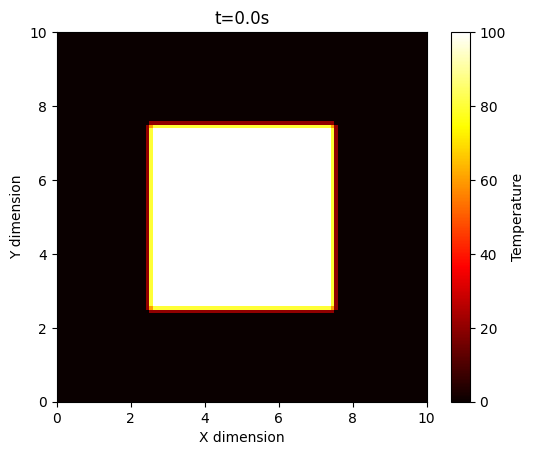

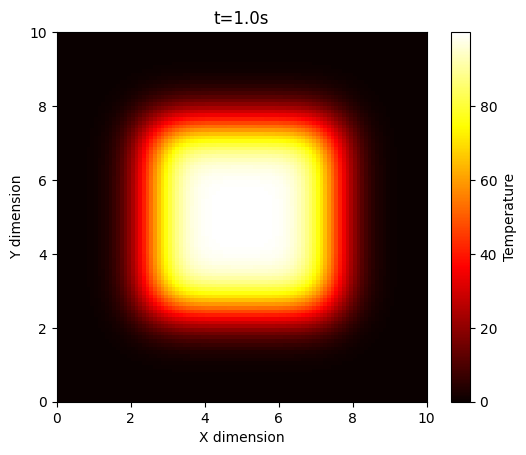

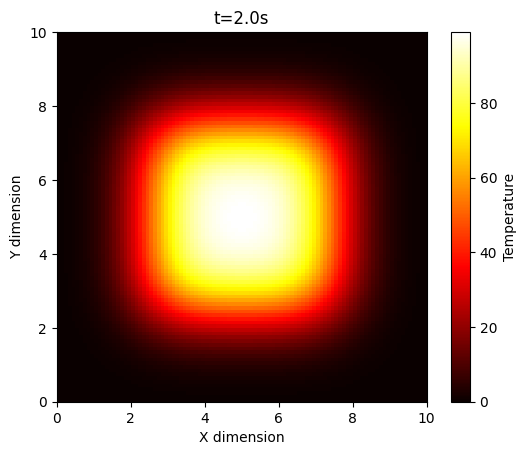

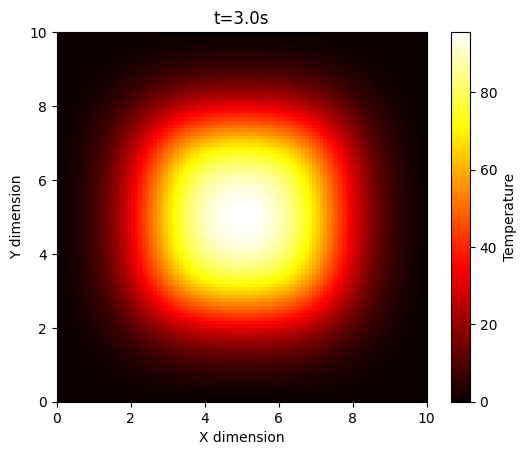

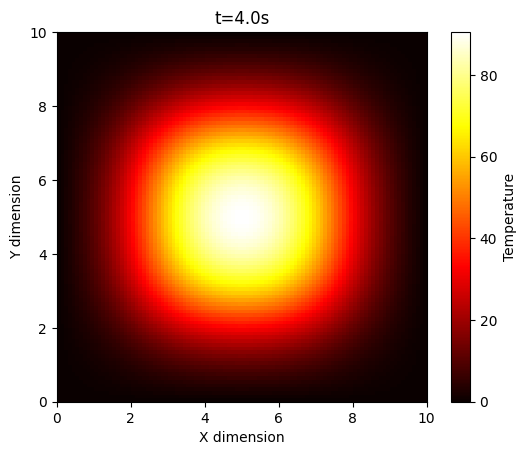

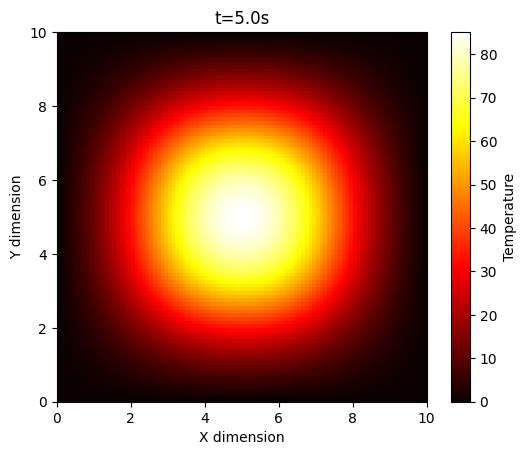

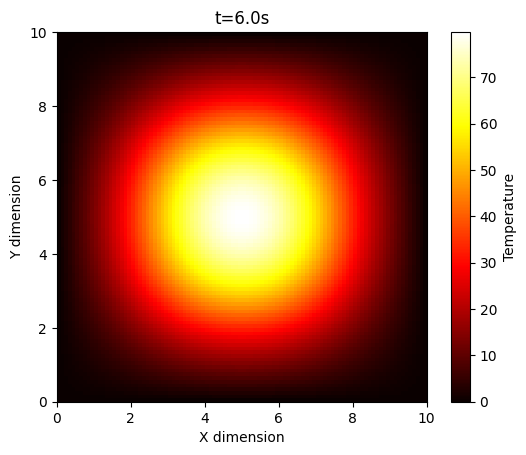

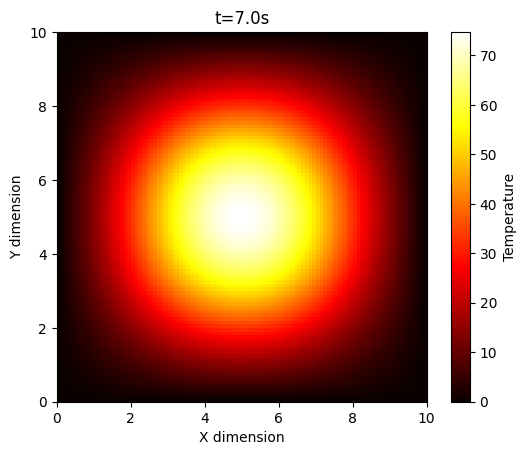

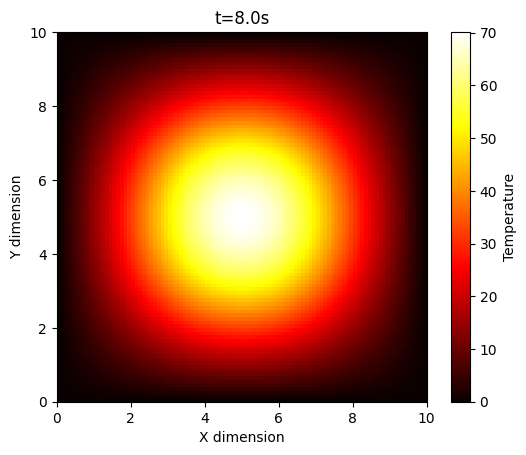

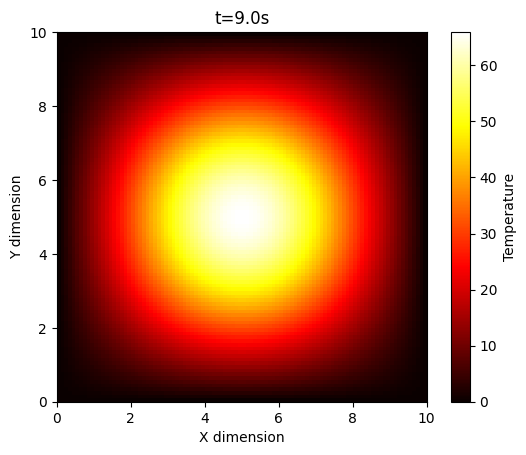

In [27]:
data_2d_path = './datasets/heat_equation_2d.csv'
dataset_2d = prepare_data_2d(data_2d_path)

In the graphs above, the initial temperature distribution had a central region set to a high temperature (100 degrees) and the boundary temperatures set to 0 degrees. Over time, heat diffuses from the hotter central region towards the cooler boundaries, aiming to reach an equilibrium state where the temperature distribution becomes uniform across the plate. This process is governed by the heat equation, which models how temperature changes in a material over time due to conduction.

### Key Points in the Heat Diffusion Process
- Initial State: The high-temperature region in the middle represents an area where heat is concentrated. The rest of the plate is initially at a uniform low temperature (0 degrees).
- Heat Diffusion: Heat begins to spread out from the higher temperature region towards the cooler areas. This is visible in the temperature distribution changes over time, where the high-temperature region expands and the overall temperature gradient between the center and the edges decreases.
- Equilibrium: Eventually, the system would reach a thermal equilibrium where the temperature is uniform across the entire plate, assuming no heat loss to the surroundings and constant boundary conditions. The time to reach equilibrium depends on the material's thermal diffusivity (α), with higher diffusivity leading to faster equilibrium.
- Boundary Effects: The fixed temperatures at the boundaries influence how heat diffuses. In this setup, the boundaries are kept at 0 degrees, continuously absorbing heat from the plate and slowing down the achievement of a uniform temperature.
- The computational model allows observing these phenomena by calculating the temperature at each point in the plate over time, using the discretized version of the heat equation. 

#### We will begin by loading the dataset generated above and transforming it into the appropriate format for the DeepyMoD model.

In [4]:
def load_data_2d():
    # load the data
    data_df = pd.read_csv(data_2d_path)
    # X and y are the spatial coordinates
    x = data_df['x'].values
    y = data_df['y'].values
    t = data_df['t'].values
    # Use 'T' as the variable of interest (target variable)
    u = data_df['T'].values
    
    # Since our data doesn't naturally form a grid, we'll directly use 'time', and 'm_t', and 'p_v' as coordinates without meshgrid
    # This approach differs from spatial-temporal PDE data but aligns with the data's nature
    coords = np.vstack((t, x, y)).T
    coords = torch.from_numpy(coords).float()
    
    # Convert 'u' to a PyTorch tensor
    data = torch.from_numpy(u.reshape(-1, 1)).float()
    # print(f"Shape of coords: {coords.shape}")
    # print(f"Shape of data (u): {data.shape}")

    return coords, data

In [23]:
# Transform and return the dataset
dataset_2d = Dataset(
    load_data_2d,
    preprocess_kwargs={
        #"noise_level": 0.01,
        "normalize_coords": False,
        "normalize_data": True
    },
    #preprocess_kwargs = {"noise_level": 0.20},
    subsampler=Subsample_random,
    # Number of samples to be sampled for training
    subsampler_kwargs={"number_of_samples": 10000},
    device=device
)

Preprocessing data
Dataset is using device:  cpu


##### For poly_order=1, the library function contains the following terms: [$1, u_x, u_y, u_{xx}, u_{yy}, u_{xy}, u, uu_x, uu_y, uu_{xx}, uu_{yy}, uu_{xy}$]

In [133]:
# Create a dataloader object for both the training and testing instances
train_dataloader, test_dataloader = get_train_test_loader(dataset_2d, train_test_split=0.8)

# Configure the network
network = NN(3, [50, 50, 50, 50], 1)
# Library
library = Library2D(poly_order=1)
# Estimator
estimator = Threshold(0.3)
# Configuration of the sparsity scheduler
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5)
# Constraint
constraint = LeastSquares()

# define the model
model_2d = DeepMoD(network, library, estimator, constraint).to(device)
# Defining optimizer
optimizer = torch.optim.Adam(
    model_2d.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3
)

In [134]:
%%time
foldername = "./data/deepymod/heat_model_2d/"
train(
    model_2d,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    log_dir=foldername,
    split=0.8,
    max_iterations=25000,
)

 18350  MSE: 5.32e-04  Reg: 3.14e-04  L1: 1.27e+00 Algorithm converged. Writing model to disk.
CPU times: total: 54.5 s
Wall time: 7min 7s


In [135]:
model_2d.constraint_coeffs()

[tensor([[0.0000],
         [0.0000],
         [0.0000],
         [0.1497],
         [0.1571],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000]], device='cuda:0', grad_fn=<MaskedScatterBackward0>)]

In [136]:
model_2d.sparsity_masks

[tensor([False, False, False,  True,  True, False, False, False, False, False,
         False, False], device='cuda:0')]

In [137]:
model_2d.estimator_coeffs()

[array([[0.       ],
        [0.       ],
        [0.       ],
        [0.5878549],
        [0.5563533],
        [0.       ],
        [0.       ],
        [0.       ],
        [0.       ],
        [0.       ],
        [0.       ],
        [0.       ]], dtype=float32)]

#### From the constraint coefficients above, we can thus see that the PDE we are trying to discover has been unearthed: $\frac{du}{dt}$ = $\alpha$($\frac{d^2u}{dx^2}$ + $\frac{d^2u}{dy^2}$) = 0.15($\frac{d^2u}{dx^2}$ + $\frac{d^2u}{dy^2}$). Ideally, the thermal  diffusivity ($\alpha$) in both dimensions (x and y) should be the same. However, this isn't the case and we will be discussing this in the end of this tutorial.

#### Let's subsample 500 training examples to see if we will end up with the same PDE discovered.

In [154]:
# Transform and return the dataset
dataset_2d_500s = Dataset(
    load_data_2d,
    preprocess_kwargs={
        #"noise_level": 0.01,
        "normalize_coords": False,
        "normalize_data": True
    },
    #preprocess_kwargs = {"noise_level": 0.20},
    subsampler=Subsample_random,
    # Number of samples to be sampled for training
    subsampler_kwargs={"number_of_samples": 500},
    device=device
)

Preprocessing data
Dataset is using device:  cuda


In [139]:
# Create a dataloader object for both the training and testing instances
train_dataloader, test_dataloader = get_train_test_loader(dataset_2d_500s, train_test_split=0.8)

# Configure the network
network = NN(3, [50, 50, 50, 50], 1)
# Library
library = Library2D(poly_order=1)
# Estimator
estimator = Threshold(0.3)
# Configuration of the sparsity scheduler
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5)
# Constraint
constraint = LeastSquares()

# define the model
model_2d_500s = DeepMoD(network, library, estimator, constraint).to(device)
# Defining optimizer
optimizer = torch.optim.Adam(
    model_2d_500s.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3
)

In [140]:
%%time
foldername = "./data/deepymod/heat_model_2d_500s/"
train(
    model_2d_500s,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    log_dir=foldername,
    split=0.8,
    max_iterations=25000,
)

 17400  MSE: 1.70e-04  Reg: 1.58e-04  L1: 1.19e+00 Algorithm converged. Writing model to disk.
CPU times: total: 54.1 s
Wall time: 6min 55s


In [141]:
model_2d_500s.constraint_coeffs()

[tensor([[0.0000],
         [0.0000],
         [0.0000],
         [0.1353],
         [0.2033],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000]], device='cuda:0', grad_fn=<MaskedScatterBackward0>)]

In [142]:
model_2d_500s.sparsity_masks

[tensor([False, False, False,  True,  True, False, False, False, False, False,
         False, False], device='cuda:0')]

In [166]:
# The estimator coefficients give the magnitude of the active terms!
model_2d_500s.estimator_coeffs()

[array([[0.        ],
        [0.        ],
        [0.        ],
        [0.49850065],
        [0.56750786],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]], dtype=float32)]

- The PDE discovered is given by: $\alpha$($\frac{d^2u}{dx^2}$ + $\frac{d^2u}{dy^2}$ = 0.17($\frac{d^2u}{dx^2}$ + $\frac{d^2u}{dy^2}$

#### How About training with 50 samples?

In [155]:
# Transform and return the dataset
dataset_2d_50s = Dataset(
    load_data_2d,
    preprocess_kwargs={
        #"noise_level": 0.01,
        "normalize_coords": False,
        "normalize_data": True
    },
    #preprocess_kwargs = {"noise_level": 0.20},
    subsampler=Subsample_random,
    # Number of samples to be sampled for training
    subsampler_kwargs={"number_of_samples": 50},
    device=device
)

Preprocessing data
Dataset is using device:  cuda


In [145]:
# Create a dataloader object for both the training and testing instances
train_dataloader, test_dataloader = get_train_test_loader(dataset_2d_50s, train_test_split=0.8)

# Configure the network
network = NN(3, [50, 50, 50, 50], 1)
# Library
library = Library2D(poly_order=1)
# Estimator
estimator = Threshold(0.3)
# Configuration of the sparsity scheduler
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5)
# Constraint
constraint = LeastSquares()

# define the model
model_2d_50s = DeepMoD(network, library, estimator, constraint).to(device)
# Defining optimizer
optimizer = torch.optim.Adam(
    model_2d_50s.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3
)

In [146]:
%%time
foldername = "./data/deepymod/heat_model_2d_50s/"
train(
    model_2d_50s,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    log_dir=foldername,
    split=0.8,
    max_iterations=25000,
)

  4950  MSE: 6.07e-06  Reg: 1.17e-05  L1: 2.32e+00 Algorithm converged. Writing model to disk.
CPU times: total: 21 s
Wall time: 2min 6s


In [147]:
model_2d_50s.constraint_coeffs()

[tensor([[-0.0685],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [-0.3027],
         [ 0.0000],
         [-0.1240],
         [ 0.0000],
         [ 0.0000],
         [ 0.4104],
         [ 0.0000],
         [ 0.0000]], device='cuda:0', grad_fn=<MaskedScatterBackward0>)]

In [148]:
model_2d_50s.sparsity_masks

[tensor([ True, False, False, False,  True, False,  True, False, False,  True,
         False, False], device='cuda:0')]

In [149]:
model_2d_50s.estimator_coeffs()

[array([[-0.6237004 ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [-0.44055155],
        [ 0.        ],
        [-0.73480886],
        [ 0.        ],
        [ 0.        ],
        [ 0.4965671 ],
        [ 0.        ],
        [ 0.        ]], dtype=float32)]

##### Why did we fail to discover the underlying PDE with 50 samples? Perhaps, not enough data to enable us discover the PDE. 

##### Let plot the subsampled datasets: (10000 samples vs 500 samples vs 50)

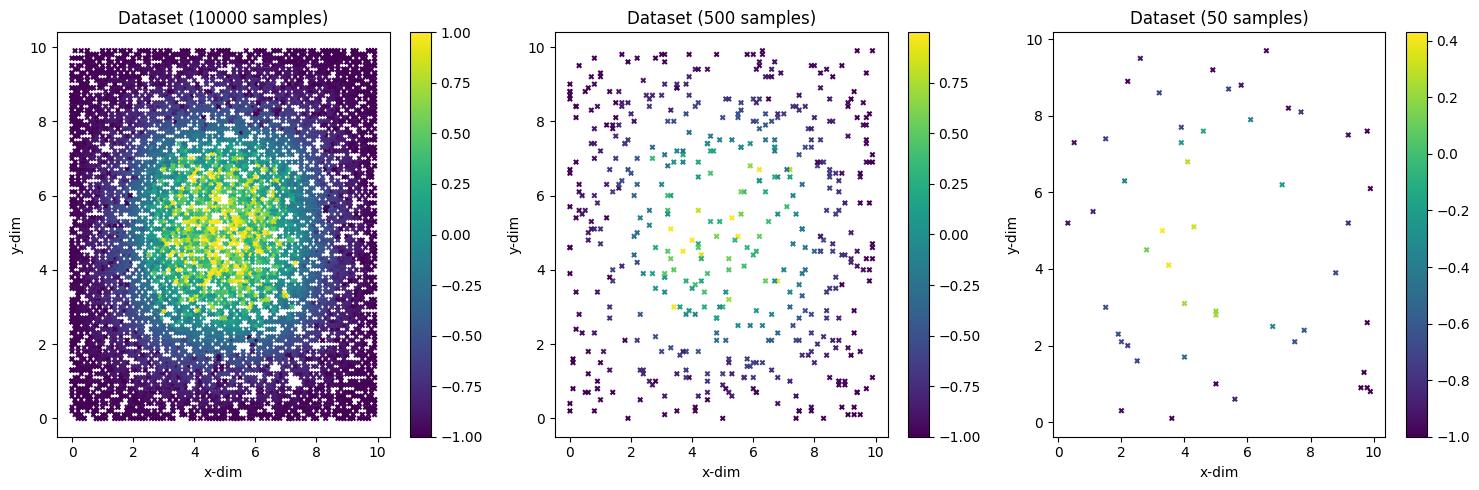

In [168]:
# Extract coordinates and data for dataset_2d_50s
coords_50s = dataset_2d_50s.get_coords().cpu()
data_50s = dataset_2d_50s.get_data().cpu()

# Extract coordinates and data for dataset_2d_500s
coords_500s = dataset_2d_500s.get_coords().cpu()
data_500s = dataset_2d_500s.get_data().cpu()

# Extract coordinates and data for dataset_2d
coords = dataset_2d.get_coords().cpu()
data = dataset_2d.get_data().cpu()

# Create subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for dataset_2d
im = axs[0].scatter(coords[:, 1], coords[:, 2], c=data[:, 0], marker="x", s=10)
axs[0].set_xlabel("x-dim")
axs[0].set_ylabel("y-dim")
axs[0].set_title("Dataset (10000 samples)")

# Plot for dataset_2d_500s
im_500s = axs[1].scatter(coords_500s[:, 1], coords_500s[:, 2], c=data_500s[:, 0], marker="x", s=10)
axs[1].set_xlabel("x-dim")
axs[1].set_ylabel("y-dim")
axs[1].set_title("Dataset (500 samples)")

# Plot for dataset_2d_50s
im_50s = axs[2].scatter(coords_50s[:, 1], coords_50s[:, 2], c=data_50s[:, 0], marker="x", s=10)
axs[2].set_xlabel("x-dim")
axs[2].set_ylabel("y-dim")
axs[2].set_title("Dataset (50 samples)")

# Add a colorbar for each plot
fig.colorbar(im, ax=axs[0])
fig.colorbar(im_500s, ax=axs[1])
fig.colorbar(im_50s, ax=axs[2])
plt.tight_layout()
plt.show()

- Evident by the graphs above, it is not hard to tell why we failed in discovering the PDE with just 50 samples. The data isn't representative enough of the phenomenon we are trying to model.
- On the other hand, with just 500 samples, we can already see the pattern in the dataset, hence, the reason why we could discover the underlying PDE with 500 samples or more

### What conclusions can one draw on the DeepyMoD library for PDE discovery?
##### The authors claim that:
- DeepMoD requires significantly less datapoints than this grid and we hence construct a smaller dataset for DeepMoD by randomly sampling the results through space and time.
- The method does not require the data to be regularly spaced or stationary in time
- The success of the approach however strongly relies on:
>- the completeness of the library functions, and
>- a threshold of small yet non-zero terms.
> (If the underlying functions are not present in the library, DeepMoD will not return the correct underlying equation. This problem however can be identified via a cross-validation procedure on a set on a spatial/temporal domain that is not present in the training data. If correct, the resultant equation should perform well outside the spatio-temporal domain of training. Conversely, since we use neural networks as function approximator, the function library, can be tailored to the problem at hand and thus contain non-linear functions of the network’s output
- For moderate noise levels, the exact value of the threshold does not impact the results significantly, for very high noise levels, more advanced sparsity selections algorithms like PDE-find or coefficient clustering schemes would be more appropriate.
- The difference between the largest non-featuring and smallest featuring terms is typically up to an order of magnitude. For very high noise levels > 20% levels the accuracy of the pruning is much more sensitive to the exact value and more advanced sparsity algorithms could be required to obtain more robust model selection (See Discussion). We then train the network one final time without L1 penalty and with the regression term only containing the terms
selected in the first cycle, to find an unbiased estimate of the coefficients of the underlying PDE

##### Comments on the results achieved and the DeepyMoD library:
- From the results obtained, we conclude that the library is capable of discovering the underlying PDE(s) of a process.
- It library is capable of discovering the underlying PDE by utilizing small sample size (as claimed by the authors)
- However, as per our example, the coefficient(s) of the discovered PDE(s) may not be exactly the same as  to the true value(s). (Further training the network could help yield the right coefficient values?)
- The threshold value used to clip off (make the library function sparse) terms whose coefficients are very small yet non-zero (signifying that they are non-active terms) requires a good understading of the problem being modelled in order to choose the right values for it. Setting the value too low may lead to non-active terms appearing in the final PDE(s), while setting the threshold value so high may essentially clip-off active terms from the final PDE(s).

#### In conclusion, the following points can be made about the DeepyMoD library:
- __Dependence on Library Construction__: The effectiveness of DeepMoD heavily relies on the construction of a comprehensive library of potential functions and their derivatives. If the actual underlying functions of the dataset are not included in the library, the algorithm cannot identify the correct PDE. This necessitates prior knowledge or assumptions about the system being studied, which might not always be available or accurate.
- __Thresholding Strategy__: The method uses a thresholding strategy to prune small coefficients to achieve a sparse representation. However, the choice of the threshold is critical and can be somewhat arbitrary. In cases of high noise or experimental data with anomalies, setting an appropriate threshold might be challenging and could influence the accuracy of the discovered model.
- __Generalization to Complex Systems__: While DeepMoD has been tested on a variety of physical systems, its ability to generalize to more complex or higher-dimensional systems is not fully explored. Systems involving more complex interactions or those that require the discovery of entirely novel forms of PDEs may pose challenges.
- __Computational Resources__: Like many deep learning approaches, the computational demand of DeepMoD can be significant, especially as the complexity of the dataset increases. The need for computational resources can be a limiting factor for broader application, particularly in scenarios where such resources are limited.
- __Handling of Non-Standard Functions__: The accompanying paper of the DeepyMoD library primarily discusses the algorithm's application to datasets that can be modeled using standard polynomial and derivative functions. Its effectiveness in dealing with datasets requiring more complex or non-standard functions (e.g., functions involving non-local interactions, fractional derivatives) is not detailed.
- __Experimental Validation__: The application of DeepyMoD to experimental data, such as the gel electrophoresis experiment, is a significant step forward. However, more extensive validation across a wider range of experimental conditions and systems is needed to fully establish its applicability and robustness in real-world scenarios.

### References:
- [Solving 1D explicit heat equation using the finite difference method](https://www-udc.ig.utexas.edu/external/becker/teaching/557/problem_sets/problem_set_fd_explicit.pdf)
- [Partial Differential Equations: Heat Conduction in a One-dimensional Rod](https://jmahaffy.sdsu.edu/courses/s17/math531/beamer/heat.pdf)
- [Numerical solution for two-dimensional partial differential equations using SM’s method](https://www.degruyter.com/document/doi/10.1515/phys-2022-0015/html?lang=en)
- [DeepyMoD documentation](https://phimal.github.io/DeePyMoD/)
- [Wikipedia: Heat equation](https://en.wikipedia.org/wiki/Heat_equation)